In [175]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('austinHousingData.csv')

# Convert 'latest_saledate' to datetime, extract numerical features
df['latest_saledate'] = pd.to_datetime(df['latest_saledate'])
df['sale_year'] = df['latest_saledate'].dt.year
df['sale_month'] = df['latest_saledate'].dt.month
df['sale_day'] = df['latest_saledate'].dt.day
df.drop(columns=['latest_saledate'], inplace=True)

# Drop irrelevant columns (0.00 importance)
irrelevant_columns = ['streetAddress', 'description', 'latestPriceSource', 'homeImage', 'hasGarage',
                      'sale_year', 'sale_month', 'city', 'homeType', 'zpid']
df.drop(columns=irrelevant_columns, inplace=True)

# Drop columns a user wouldn't likely be able to access
user_unavailable_columns = ['numPriceChanges', 'avgSchoolSize', 'avgSchoolRating', 'avgSchoolDistance',
                            'numOfPhotos', 'latest_saleyear', 'latest_salemonth', 'sale_day',
                            'MedianStudentsPerTeacher', 'numOfElementarySchools', 'numOfHighSchools',
                            'numOfMiddleSchools', 'numOfPrimarySchools']
df.drop(columns=user_unavailable_columns, inplace=True)

# Drop low-importance columns
low_importance_columns = ['numOfAccessibilityFeatures', 'numOfCommunityFeatures', 'hasCooling',
                          'hasHeating', 'numOfWindowFeatures', 'numOfSecurityFeatures', 'hasView',
                          'parkingSpaces', 'propertyTaxRate', 'hasSpa', 'numOfWaterfrontFeatures']
df.drop(columns=low_importance_columns, inplace=True)

# Add feature interaction columns
df['PricePerSqFt'] = df['latestPrice'] / df['livingAreaSqFt']
df['BathBedRatio'] = df['numOfBathrooms'] / df['numOfBedrooms']
df['LotLivingRatio'] = df['lotSizeSqFt'] / df['livingAreaSqFt']
df['GarageBedRatio'] = df['garageSpaces'] / df['numOfBedrooms']
df['LatLonInteraction'] = df['latitude'] * df['longitude']

# Handle potential division by zero
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Split dataset into features and target variable
target = 'latestPrice'
X = df.drop(columns=[target])
y = df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Base LightGBM parameters
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1
}

# Optimized LightGBM params from Optuna
optimized_params = {
    **base_params,
    'learning_rate': 0.058793153916846676,
    'num_leaves': 63,
    'max_depth': 16,
    'min_data_in_leaf': 11,
    'feature_fraction': 0.8957209852243492,
    'bagging_fraction': 0.8868935737344777,
    'bagging_freq': 7,
    'lambda_l1': 0.5825558284248297,
    'lambda_l2': 0.005388605992909206
}

# Adjusted LightGBM params
adjusted_params = {
    **optimized_params,
    'learning_rate': 0.02,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0
}

# Modular functions for training and evaluation
def train_lightgbm(params, train_data, test_data, num_boost_round=1000, early_stopping_rounds=50):
    model = lgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[train_data, test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds), lgb.log_evaluation(100)]
    )
    return model

def evaluate_lightgbm(model, X_test, y_test):
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2

# Training and evaluation with optimized params
print("Training with optimized params...")
model = train_lightgbm(optimized_params, train_data, test_data)
rmse, mae, r2 = evaluate_lightgbm(model, X_test, y_test)
print(f"Optimized RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Training and evaluation with adjusted params
print("Training with adjusted params...")
model = train_lightgbm(adjusted_params, train_data, test_data, num_boost_round=2000, early_stopping_rounds=100)
rmse, mae, r2 = evaluate_lightgbm(model, X_test, y_test)
print(f"Adjusted RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Cross-validation to check stability
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = train_lightgbm(adjusted_params, train_data, val_data, num_boost_round=2000, early_stopping_rounds=100)
    rmse, mae, r2 = evaluate_lightgbm(model, X_val, y_val)
    cv_results.append((rmse, mae, r2))

# Aggregate cross-validation results
cv_rmse, cv_mae, cv_r2 = map(lambda x: (np.mean(x), np.std(x)), zip(*cv_results))
print(f"Cross-Validation Results - RMSE: {cv_rmse[0]} ± {cv_rmse[1]}, MAE: {cv_mae[0]} ± {cv_mae[1]}, R^2: {cv_r2[0]} ± {cv_r2[1]}")


Training with optimized params...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 64983.7	valid_1's rmse: 172108
[200]	training's rmse: 41763	valid_1's rmse: 171163
Early stopping, best iteration is:
[206]	training's rmse: 40403.6	valid_1's rmse: 170056
Optimized RMSE: 170055.62459831024, MAE: 15097.330213809764, R^2: 0.8778113389663517
Training with adjusted params...
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[100]	training's rmse: 121995	valid_1's rmse: 207963
[200]	training's rmse: 79187.4	valid_1's rmse: 179887
[300]	training's rmse: 63900.3	valid_1's rmse: 173966
[400]	training's rmse: 53804.1	valid_1's rmse: 172560
[500]	training's rmse: 45852.6	valid_1's rmse: 171713
[600]	training's rmse: 39512.1	valid_1's rmse: 171972
[700]	training's rmse: 34149.4	valid_1's rmse: 171409
Early stopping, best iteration is:
[651]	training's rmse: 36604.9	valid_1's rmse: 171118


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Adjusted RMSE: 171118.0353762204, MAE: 15184.299236393625, R^2: 0.8762798394414132
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 122798	valid_1's rmse: 213097
[200]	training's rmse: 79226.5	valid_1's rmse: 183386
[300]	training's rmse: 64839.3	valid_1's rmse: 179168
[400]	training's rmse: 55054.2	valid_1's rmse: 177232
Early stopping, best iteration is:
[399]	training's rmse: 55108.4	valid_1's rmse: 177109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117410	valid_1's rmse: 222484
[200]	training's rmse: 72472.8	valid_1's rmse: 169226
[300]	training's rmse: 61370.3	valid_1's rmse: 153885
[400]	training's rmse: 53548.4	valid_1's rmse: 152177
[500]	training's rmse: 47092.5	valid_1's rmse: 149003
Early stopping, best iteration is:
[483]	training's rmse: 48341.4	valid_1's rmse: 148445


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 131226	valid_1's rmse: 103276
[200]	training's rmse: 85595.4	valid_1's rmse: 54352.9
[300]	training's rmse: 70478.1	valid_1's rmse: 50392.8
[400]	training's rmse: 60101.2	valid_1's rmse: 48297.8
Early stopping, best iteration is:
[380]	training's rmse: 61855.1	valid_1's rmse: 47874.7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 127665	valid_1's rmse: 69594.2
[200]	training's rmse: 82897.8	valid_1's rmse: 59337.6
[300]	training's rmse: 67459.9	valid_1's rmse: 60208.1
Early stopping, best iteration is:
[265]	training's rmse: 72286.9	valid_1's rmse: 57625.2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 140336	valid_1's rmse: 105355
[200]	training's rmse: 86514	valid_1's rmse: 72821.9
[300]	training's rmse: 70236.5	valid_1's rmse: 75008.8
Early stopping, best iteration is:
[217]	training's rmse: 83337.9	valid_1's rmse: 71785.9
Cross-Validation Results - RMSE: 100568.06665281212 ± 52153.38709783, MAE: 14452.09512008922 ± 1714.8132303520854, R^2: 0.9449365090016217 ± 0.04508958256796622


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [174]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('austinHousingData.csv')

df.head()

# Convert 'latest_saledate' to datetime, extract numerical features
df['latest_saledate'] = pd.to_datetime(df['latest_saledate'])
df['sale_year'] = df['latest_saledate'].dt.year
df['sale_month'] = df['latest_saledate'].dt.month
df['sale_day'] = df['latest_saledate'].dt.day
df.drop(columns=['latest_saledate'], inplace=True)

# Drop irrelevant columns (0.00 importance)
irrelevant_columns = ['streetAddress', 'description', 'latestPriceSource', 'homeImage', 'hasGarage',
                      'sale_year', 'sale_month', 'city', 'homeType', 'zpid']
df.drop(columns=irrelevant_columns, inplace=True)

# Drop columns a user wouldn't likely be able to access
user_unavailable_columns = ['numPriceChanges', 'avgSchoolSize', 'avgSchoolRating', 'avgSchoolDistance',
                            'numOfPhotos', 'latest_saleyear', 'latest_salemonth', 'sale_day',
                            'MedianStudentsPerTeacher', 'numOfElementarySchools', 'numOfHighSchools',
                            'numOfMiddleSchools', 'numOfPrimarySchools']
df.drop(columns=user_unavailable_columns, inplace=True)

# Drop low-importance columns
low_importance_columns = ['numOfAccessibilityFeatures', 'numOfCommunityFeatures', 'hasCooling',
                          'hasHeating', 'numOfWindowFeatures', 'numOfSecurityFeatures', 'hasView',
                          'parkingSpaces', 'propertyTaxRate', 'hasSpa', 'numOfWaterfrontFeatures']
df.drop(columns=low_importance_columns, inplace=True)

# Add feature interaction columns
df['PricePerSqFt'] = df['latestPrice'] / df['livingAreaSqFt']
df['BathBedRatio'] = df['numOfBathrooms'] / df['numOfBedrooms']
df['LotLivingRatio'] = df['lotSizeSqFt'] / df['livingAreaSqFt']
df['GarageBedRatio'] = df['garageSpaces'] / df['numOfBedrooms']
df['LatLonInteraction'] = df['latitude'] * df['longitude']

# Handle potential division by zero
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Split dataset into features and target variable
target = 'latestPrice'
X = df.drop(columns=[target])
y = df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Optimized LightGBM params from Optuna
optimized_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.058793153916846676,
    'num_leaves': 63,
    'max_depth': 16,
    'min_data_in_leaf': 11,
    'feature_fraction': 0.8957209852243492,
    'bagging_fraction': 0.8868935737344777,
    'bagging_freq': 7,
    'lambda_l1': 0.5825558284248297,
    'lambda_l2': 0.005388605992909206,
    'verbosity': -1
}

# Train the LightGBM model
print("Training LightGBM...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

# Evaluate the model
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LightGBM RMSE: {rmse}")
print(f"LightGBM MAE: {mae}")
print(f"LightGBM R^2: {r2}")

# Adjusted LightGBM params
adjusted_params = optimized_params.copy()
adjusted_params['learning_rate'] = 0.02
adjusted_params['lambda_l1'] = 0.5
adjusted_params['lambda_l2'] = 1.0

# Train LightGBM with adjusted learning rate
print("Training LightGBM with smaller learning rate...")
model = lgb.train(
    adjusted_params,
    train_data,
    num_boost_round=2000,  # Increased to allow more boosting rounds
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)

# Evaluate the model
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Adjusted LightGBM RMSE: {rmse}")
print(f"Adjusted LightGBM MAE: {mae}")
print(f"Adjusted LightGBM R^2: {r2}")


Training LightGBM...
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 197408	valid_1's rmse: 268746
[100]	training's rmse: 116940	valid_1's rmse: 200980
[150]	training's rmse: 88516.9	valid_1's rmse: 179297
[200]	training's rmse: 75724.1	valid_1's rmse: 174961
[250]	training's rmse: 67578.8	valid_1's rmse: 171468
[300]	training's rmse: 61721.4	valid_1's rmse: 171266
[350]	training's rmse: 56023.1	valid_1's rmse: 171262
Early stopping, best iteration is:
[310]	training's rmse: 60365.7	valid_1's rmse: 170485


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LightGBM RMSE: 170484.76114724868
LightGBM MAE: 13516.873806869959
LightGBM R^2: 0.8771938729899653
Training LightGBM with smaller learning rate...
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 121995	valid_1's rmse: 207963
[200]	training's rmse: 79187.4	valid_1's rmse: 179887
[300]	training's rmse: 63900.3	valid_1's rmse: 173966
[400]	training's rmse: 53804.1	valid_1's rmse: 172560
[500]	training's rmse: 45852.6	valid_1's rmse: 171713
[600]	training's rmse: 39512.1	valid_1's rmse: 171972
[700]	training's rmse: 34149.4	valid_1's rmse: 171409
Early stopping, best iteration is:
[651]	training's rmse: 36604.9	valid_1's rmse: 171118
Adjusted LightGBM RMSE: 171118.0353762204
Adjusted LightGBM MAE: 15184.299236393625
Adjusted LightGBM R^2: 0.8762798394414132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [173]:
from itertools import product

# Grid of values to test
l1_values = [0.5, 1.0, 2.0]
l2_values = [0.01, 0.1, 1.0]

best_rmse = float('inf')
best_params = None

for l1, l2 in product(l1_values, l2_values):
    adjusted_params['lambda_l1'] = l1
    adjusted_params['lambda_l2'] = l2
    model = lgb.train(
        adjusted_params,
        train_data,
        num_boost_round=2000,
        valid_sets=[train_data, test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (l1, l2)

print(f"Best Regularization Parameters: L1 = {best_params[0]}, L2 = {best_params[1]}")
print(f"Best RMSE: {best_rmse}")

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117467	valid_1's rmse: 204309
[200]	training's rmse: 76838	valid_1's rmse: 180606
[300]	training's rmse: 62110.2	valid_1's rmse: 176709
[400]	training's rmse: 51934.8	valid_1's rmse: 174908
[500]	training's rmse: 43932.5	valid_1's rmse: 173651
Early stopping, best iteration is:
[453]	training's rmse: 47326.3	valid_1's rmse: 173564


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117830	valid_1's rmse: 205083
[200]	training's rmse: 76903.9	valid_1's rmse: 180488
[300]	training's rmse: 62204.2	valid_1's rmse: 176372
[400]	training's rmse: 52096.3	valid_1's rmse: 174576
[500]	training's rmse: 44073.7	valid_1's rmse: 174032
Early stopping, best iteration is:
[434]	training's rmse: 49047.6	valid_1's rmse: 173814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 121995	valid_1's rmse: 207963
[200]	training's rmse: 79187.4	valid_1's rmse: 179887
[300]	training's rmse: 63900.3	valid_1's rmse: 173966
[400]	training's rmse: 53804.1	valid_1's rmse: 172560
[500]	training's rmse: 45852.6	valid_1's rmse: 171713
[600]	training's rmse: 39512.1	valid_1's rmse: 171972
[700]	training's rmse: 34149.4	valid_1's rmse: 171409
Early stopping, best iteration is:
[651]	training's rmse: 36604.9	valid_1's rmse: 171118


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117467	valid_1's rmse: 204309
[200]	training's rmse: 76838	valid_1's rmse: 180606
[300]	training's rmse: 62110.2	valid_1's rmse: 176709
[400]	training's rmse: 51934.8	valid_1's rmse: 174908
[500]	training's rmse: 43932.5	valid_1's rmse: 173651
Early stopping, best iteration is:
[453]	training's rmse: 47326.3	valid_1's rmse: 173564


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117830	valid_1's rmse: 205083
[200]	training's rmse: 76903.9	valid_1's rmse: 180488
[300]	training's rmse: 62204.2	valid_1's rmse: 176372
[400]	training's rmse: 52096.3	valid_1's rmse: 174576
[500]	training's rmse: 44073.5	valid_1's rmse: 174033
Early stopping, best iteration is:
[434]	training's rmse: 49047.6	valid_1's rmse: 173814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 121995	valid_1's rmse: 207963
[200]	training's rmse: 79187.4	valid_1's rmse: 179887
[300]	training's rmse: 63900.3	valid_1's rmse: 173966
[400]	training's rmse: 53804.1	valid_1's rmse: 172560
[500]	training's rmse: 45852.6	valid_1's rmse: 171713
[600]	training's rmse: 39512.1	valid_1's rmse: 171972
[700]	training's rmse: 34149.4	valid_1's rmse: 171409
Early stopping, best iteration is:
[651]	training's rmse: 36604.9	valid_1's rmse: 171118


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117467	valid_1's rmse: 204309
[200]	training's rmse: 76838	valid_1's rmse: 180625
[300]	training's rmse: 62073.3	valid_1's rmse: 176822
[400]	training's rmse: 51848.8	valid_1's rmse: 175210
[500]	training's rmse: 43905.3	valid_1's rmse: 174009
Early stopping, best iteration is:
[455]	training's rmse: 47072.6	valid_1's rmse: 173706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 117830	valid_1's rmse: 205083
[200]	training's rmse: 76903.9	valid_1's rmse: 180488
[300]	training's rmse: 62204.2	valid_1's rmse: 176372
[400]	training's rmse: 52096.3	valid_1's rmse: 174576
[500]	training's rmse: 44073.5	valid_1's rmse: 174033
Early stopping, best iteration is:
[434]	training's rmse: 49047.7	valid_1's rmse: 173814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 121995	valid_1's rmse: 207963
[200]	training's rmse: 79187.4	valid_1's rmse: 179887
[300]	training's rmse: 63900.3	valid_1's rmse: 173966
[400]	training's rmse: 53804.1	valid_1's rmse: 172560
[500]	training's rmse: 45851.7	valid_1's rmse: 171711
[600]	training's rmse: 39511	valid_1's rmse: 171958
[700]	training's rmse: 34140.1	valid_1's rmse: 171463
Early stopping, best iteration is:
[652]	training's rmse: 36565.9	valid_1's rmse: 171156
Best Regularization Parameters: L1 = 0.5, L2 = 1.0
Best RMSE: 171118.0353762204


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [167]:
from sklearn.model_selection import KFold
import numpy as np

# Define number of splits for K-fold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store metrics for each fold
rmse_scores = []
mae_scores = []
r2_scores = []

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}...")

    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict and evaluate
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store metrics
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold + 1} - RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Calculate and display average metrics
print("\nCross-Validation Results:")
print(f"Average RMSE: {np.mean(rmse_scores)} ± {np.std(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}")
print(f"Average R^2: {np.mean(r2_scores)} ± {np.std(r2_scores)}")

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nAnalyzing fold {fold + 1}...")
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Analyze target variable distribution
    print(f"Target variable mean (train): {y_train.mean()}, std: {y_train.std()}")
    print(f"Target variable mean (test): {y_test.mean()}, std: {y_test.std()}")

    # Check for outliers in the target variable
    print(f"Target variable min (test): {y_test.min()}, max: {y_test.max()}")

    # Analyze feature distribution (e.g., livingAreaSqFt)
    print(f"Feature 'livingAreaSqFt' mean (train): {X_train['livingAreaSqFt'].mean()}, std: {X_train['livingAreaSqFt'].std()}")
    print(f"Feature 'livingAreaSqFt' mean (test): {X_test['livingAreaSqFt'].mean()}, std: {X_test['livingAreaSqFt'].std()}")



Training fold 1...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 - RMSE: 171145.2224910144, MAE: 14177.037576221232, R^2: 0.8762405231717657
Training fold 2...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 - RMSE: 145164.34700136833, MAE: 13978.425808346468, R^2: 0.9241552902680077
Training fold 3...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 - RMSE: 50559.85536641351, MAE: 10345.439192890257, R^2: 0.9860812171929189
Training fold 4...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 - RMSE: 54041.448943537136, MAE: 16496.418727161337, R^2: 0.9798687726152356
Training fold 5...
Fold 5 - RMSE: 76927.30242897492, MAE: 12459.653461820586, R^2: 0.9677296134822007

Cross-Validation Results:
Average RMSE: 99567.63524626165 ± 49374.87603378466
Average MAE: 13491.394953287978 ± 2034.6498909296824
Average R^2: 0.9468150833460257 ± 0.041390887834240574

Analyzing fold 1...
Target variable mean (train): 512802.46877059987, std: 444465.248370803
Target variable mean (test): 512628.889291598, std: 486571.9930269911
Target variable min (test): 6800.0, max: 13000000.0
Feature 'livingAreaSqFt' mean (train): 2209.5365853658536, std: 1452.1994938374019
Feature 'livingAreaSqFt' mean (test): 2203.4718286655684, std: 1033.1954095099738

Analyzing fold 2...
Target variable mean (train): 510962.5120705281, std: 432718.0212491622
Target variable mean (test): 519989.2653263019, std: 527192.1089965529
Target variable min (test): 21500.0, max: 13500000.0
Feature 'livingAreaSqFt' mean 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [165]:
feature_importances = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nAnalyzing feature importance for fold {fold + 1}...")
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train model
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Collect feature importance
    importance = model.feature_importance(importance_type='gain')
    feature_importances.append(importance)

# Aggregate feature importance across folds
avg_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Importance': avg_importance
}).sort_values(by='Average Importance', ascending=False)

print("Feature Importance Across Folds:")
print(feature_importance_df)



Analyzing feature importance for fold 1...

Analyzing feature importance for fold 2...

Analyzing feature importance for fold 3...

Analyzing feature importance for fold 4...

Analyzing feature importance for fold 5...
Feature Importance Across Folds:
                       Feature  Average Importance
10              livingAreaSqFt        2.415329e+16
14                PricePerSqFt        2.081472e+16
11              numOfBathrooms        6.860479e+14
18           LatLonInteraction        3.896665e+14
1                     latitude        3.689986e+14
9                  lotSizeSqFt        2.816123e+14
19                     Central        1.726670e+14
2                    longitude        1.156889e+14
5                    yearBuilt        7.681884e+13
16              LotLivingRatio        6.782501e+13
15                BathBedRatio        6.572539e+13
12               numOfBedrooms        4.556080e+13
0                      zipcode        3.861598e+13
6              numOfAppliances   

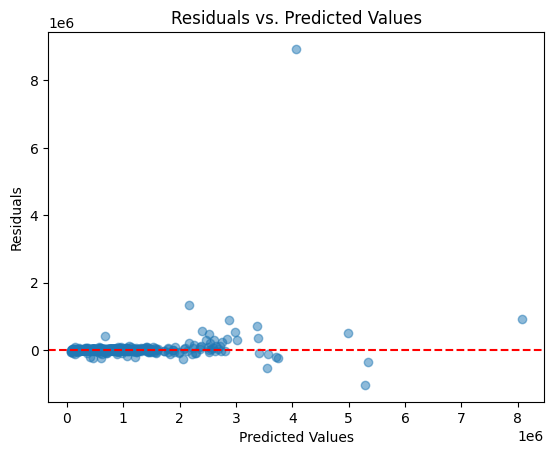

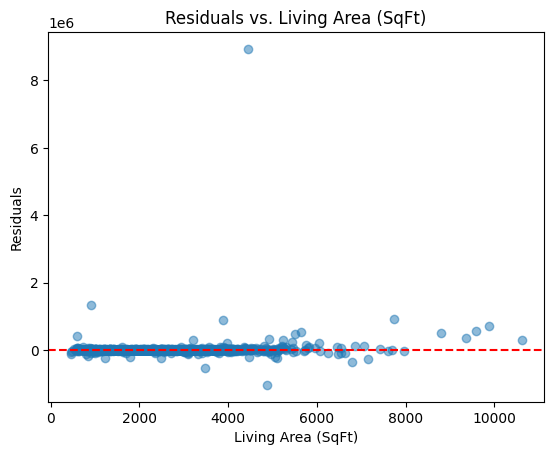

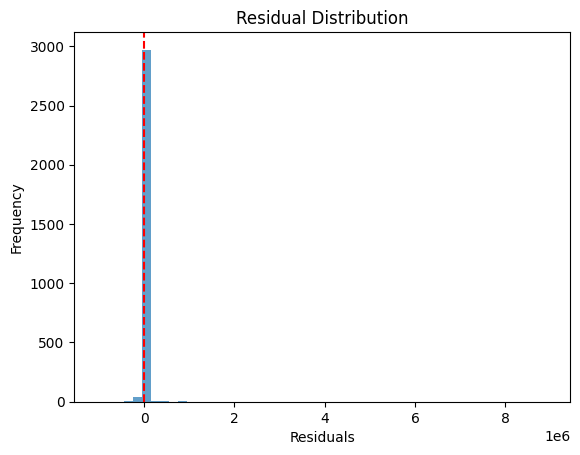

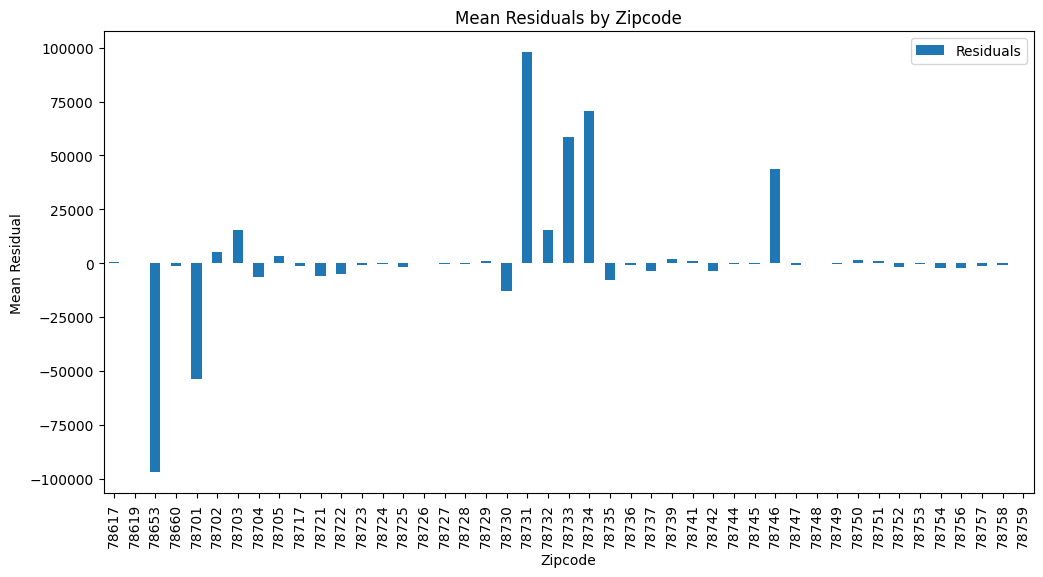

In [138]:
# Compute residuals
residuals = y_test - y_pred

import matplotlib.pyplot as plt

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Example with livingAreaSqFt
plt.scatter(X_test['livingAreaSqFt'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Living Area (SqFt)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Living Area (SqFt)')
plt.show()

plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

# Group residuals by zipcode
grouped_residuals = pd.DataFrame({'Residuals': residuals, 'Zipcode': X_test['zipcode']})
grouped_mean = grouped_residuals.groupby('Zipcode').mean()

# Plot grouped residuals
grouped_mean.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Mean Residual')
plt.title('Mean Residuals by Zipcode')
plt.show()




Analyzing residuals for fold 1...


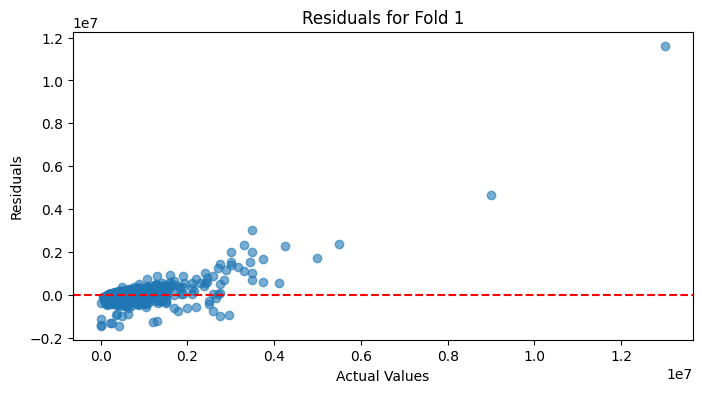


Analyzing residuals for fold 2...


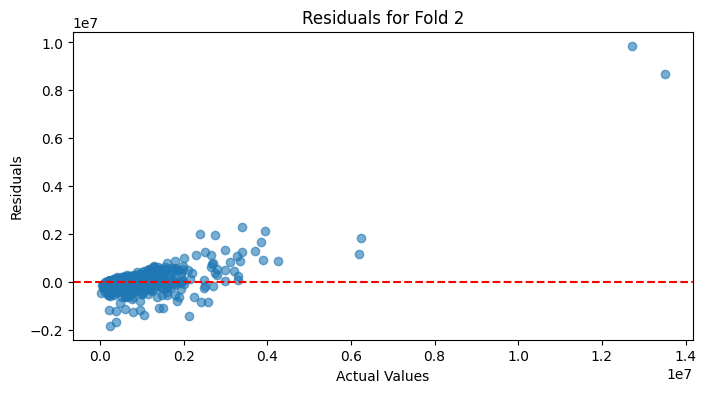


Analyzing residuals for fold 3...


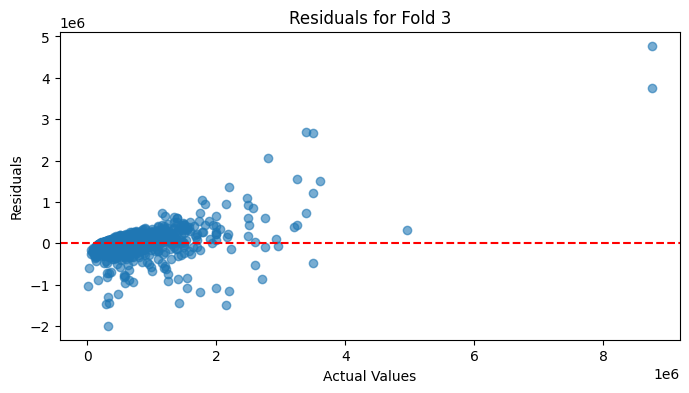


Analyzing residuals for fold 4...


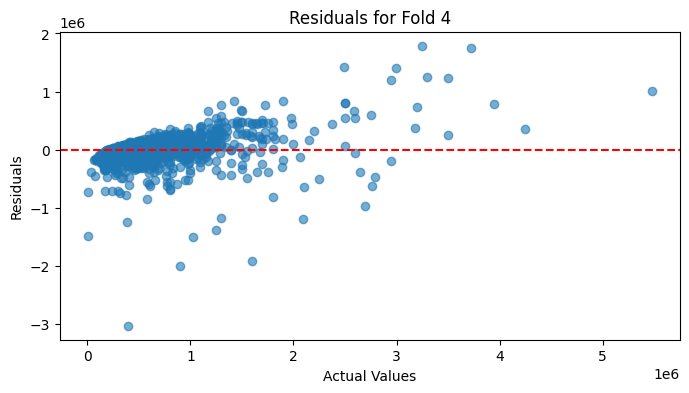


Analyzing residuals for fold 5...


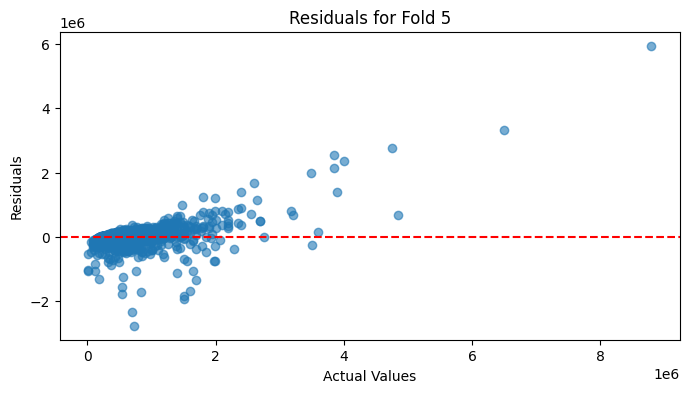

In [110]:
import matplotlib.pyplot as plt

# Store residuals for each fold
residuals = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nAnalyzing residuals for fold {fold + 1}...")
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train model
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict and calculate residuals
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    residual = y_test - y_pred
    residuals.append(residual)

    # Plot residuals
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, residual, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residuals for Fold {fold + 1}")
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.show()


In [124]:
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10),
        'verbosity': -1
    }

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict and calculate RMSE
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters and RMSE
best_params = study.best_params
best_rmse = study.best_value

print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)


[I 2024-12-04 03:51:51,982] A new study created in memory with name: no-name-10303284-3d62-4da6-8773-fd9dcf64db01
<ipython-input-124-1341cb521773>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-124-1341cb521773>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-124-1341cb521773>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bag

Best parameters: {'learning_rate': 0.058793153916846676, 'num_leaves': 63, 'max_depth': 16, 'min_data_in_leaf': 11, 'feature_fraction': 0.8957209852243492, 'bagging_fraction': 0.8868935737344777, 'bagging_freq': 7, 'lambda_l1': 0.5825558284248297, 'lambda_l2': 0.005388605992909206}
Best RMSE: 296952.9439726042


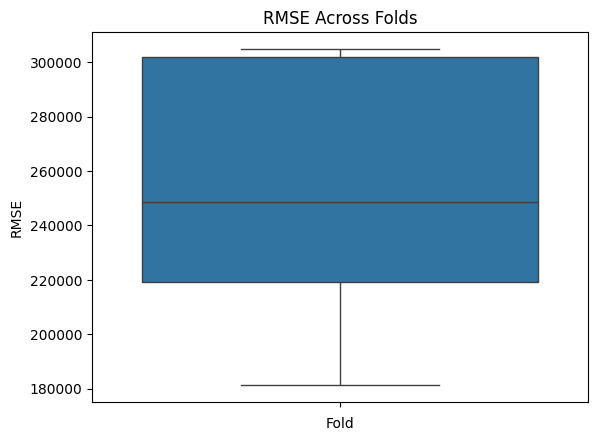

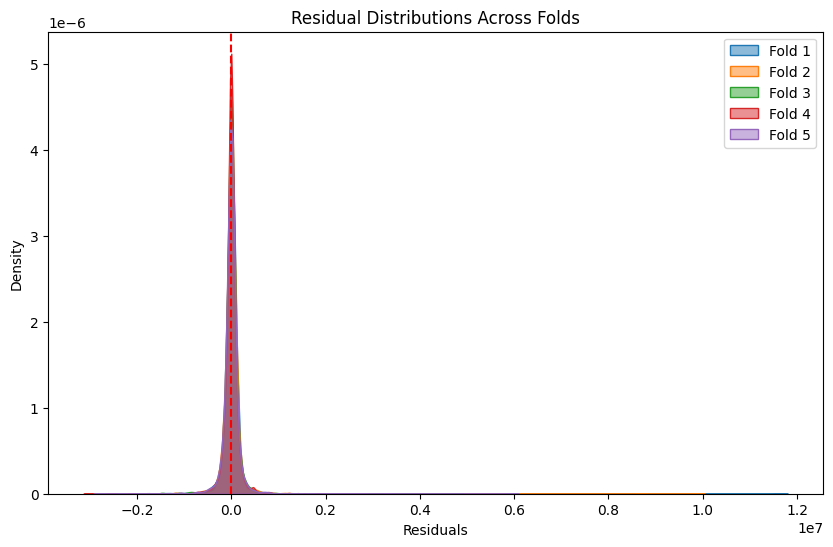

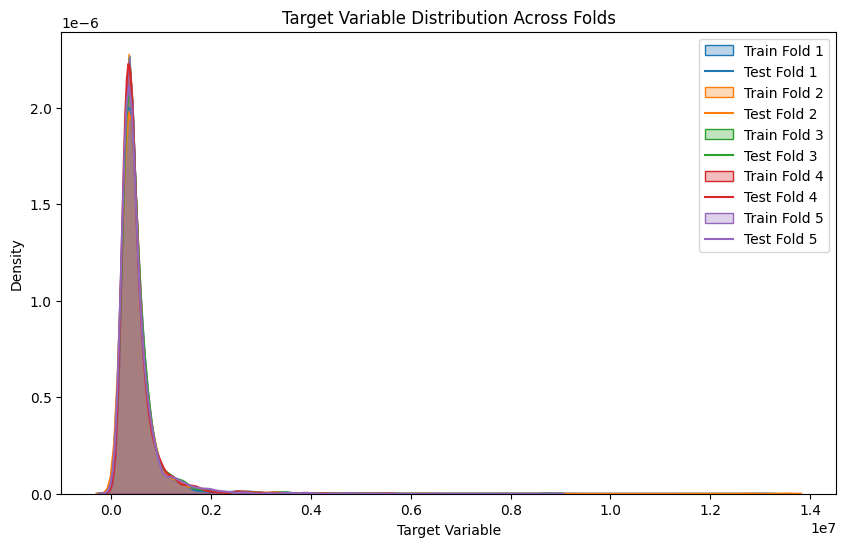

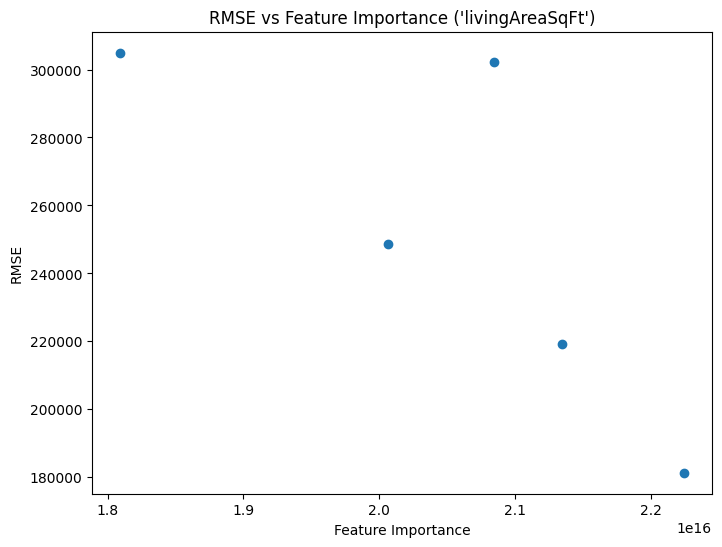

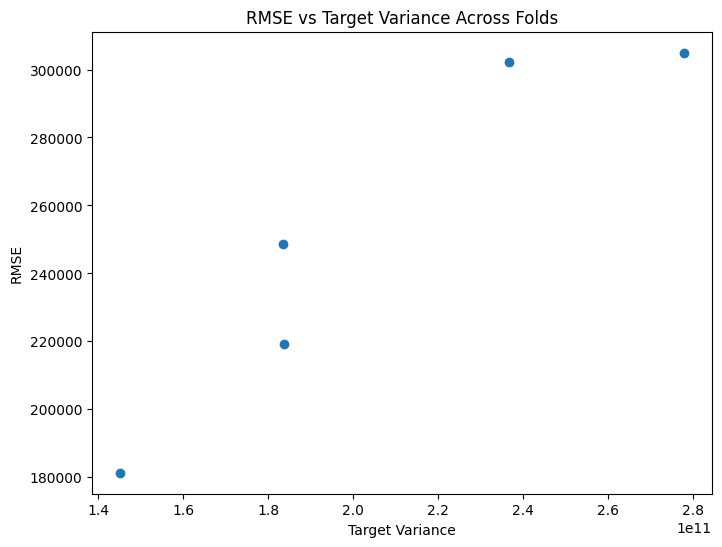

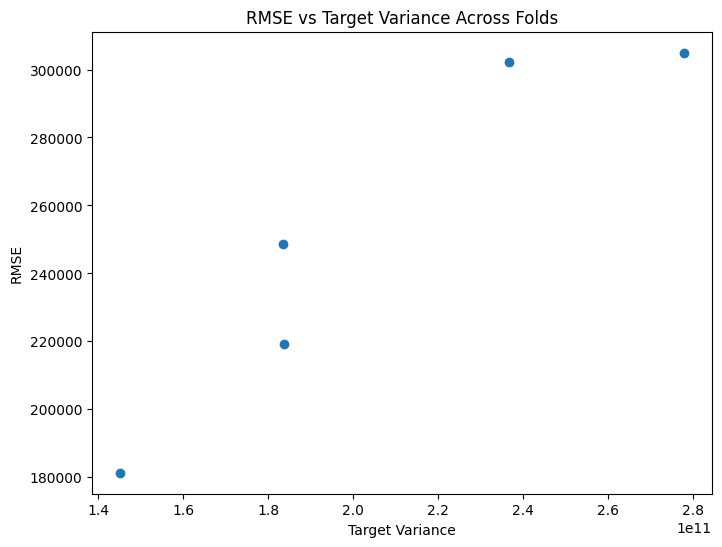

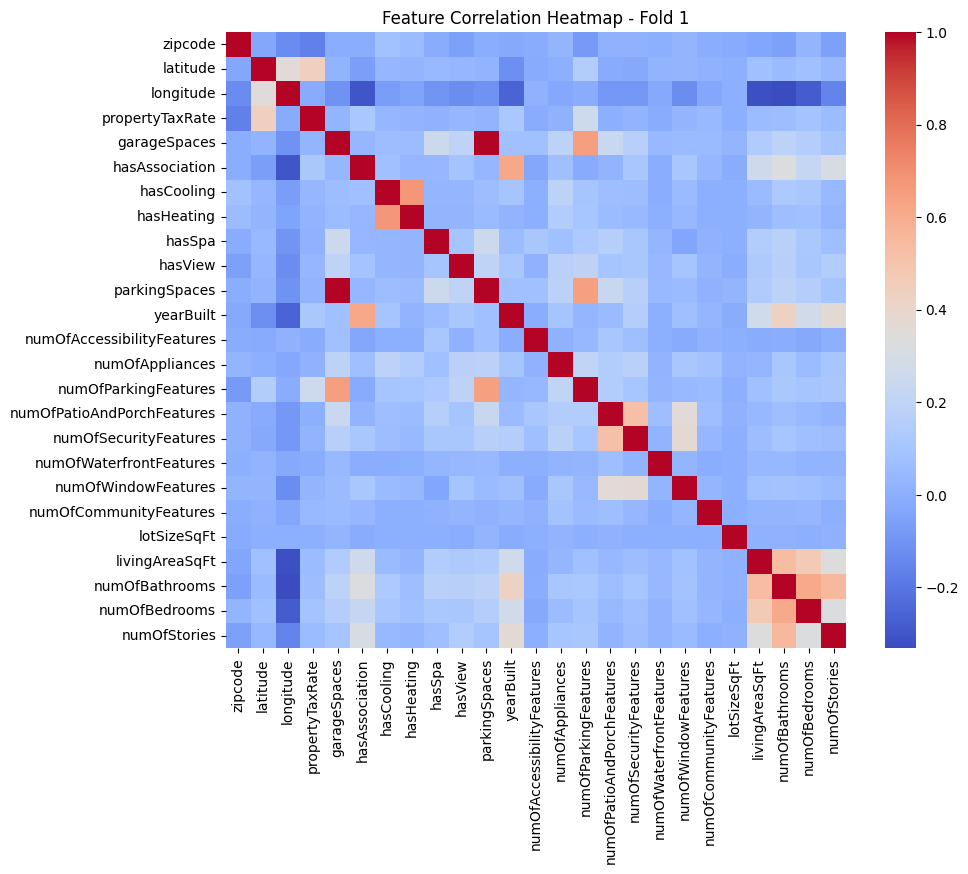

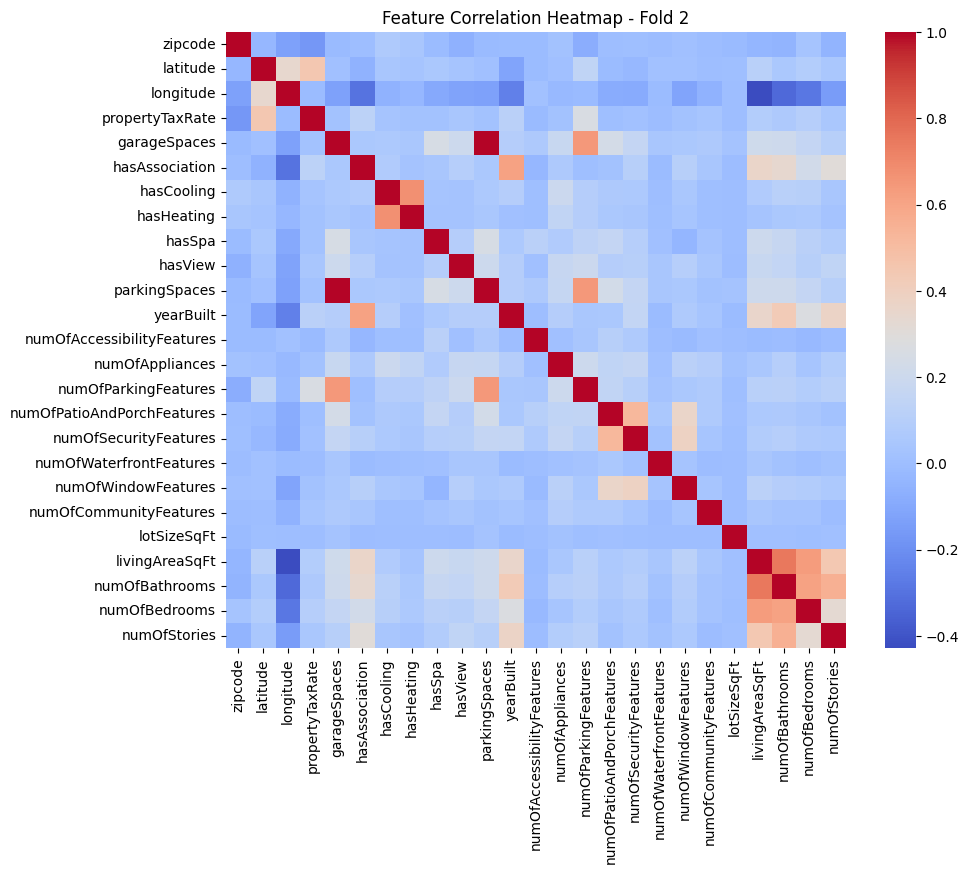

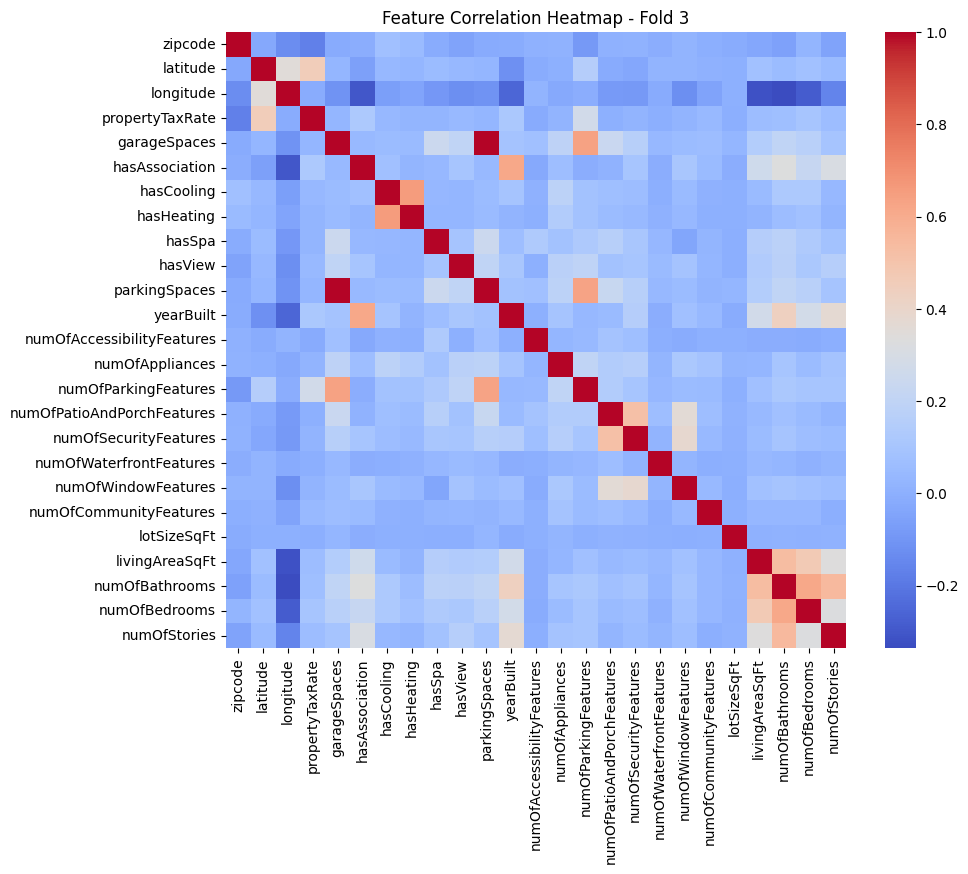

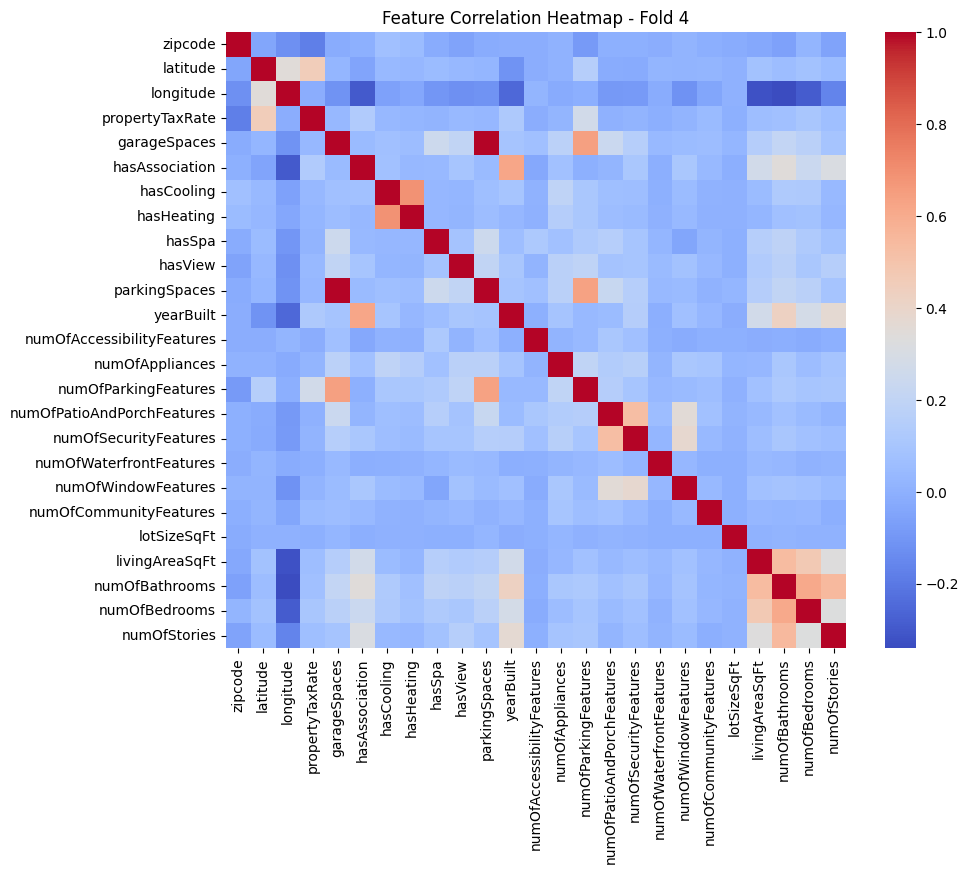

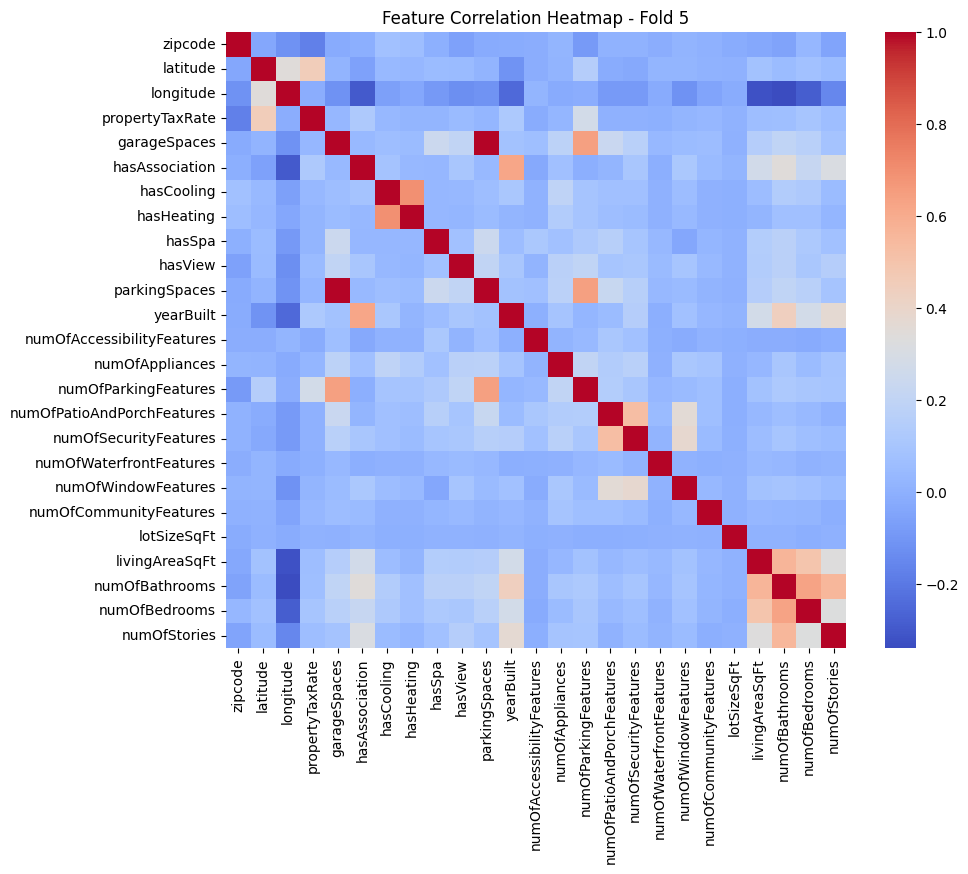

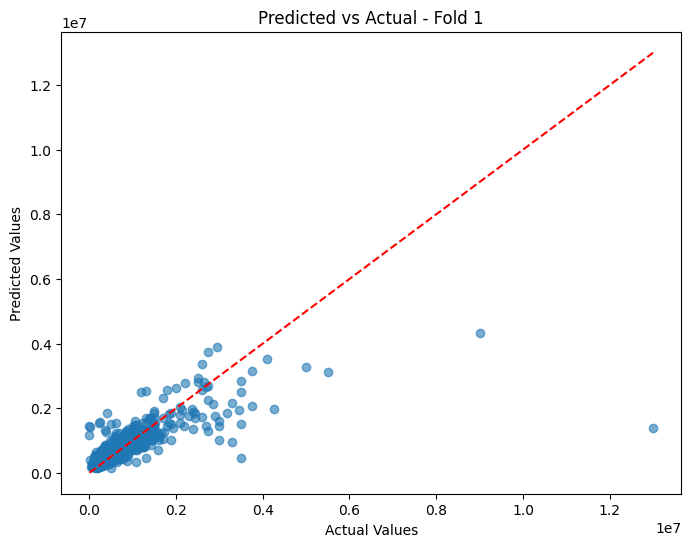

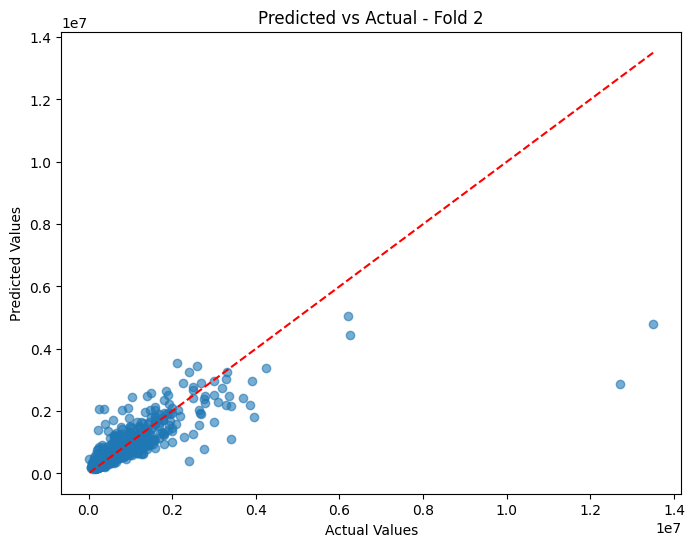

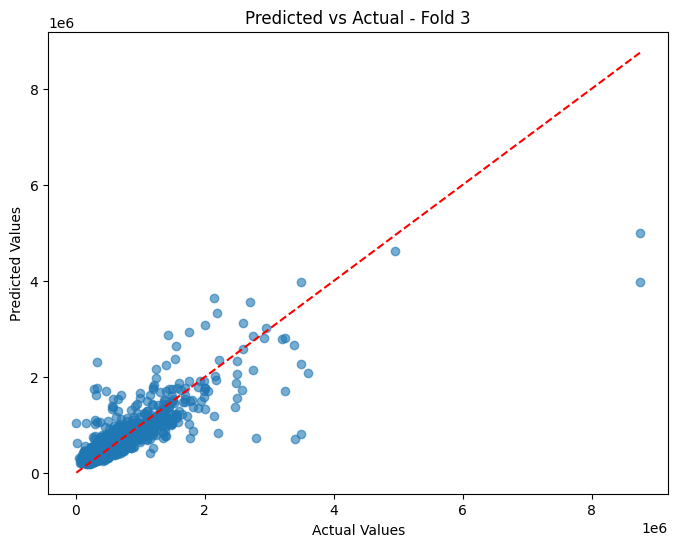

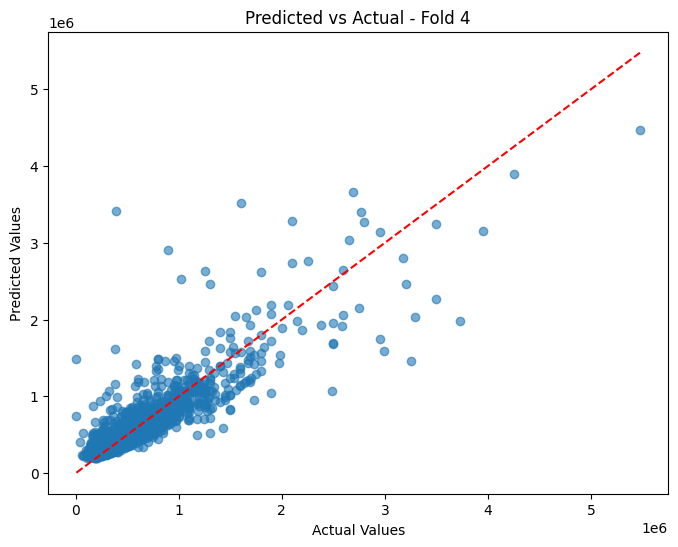

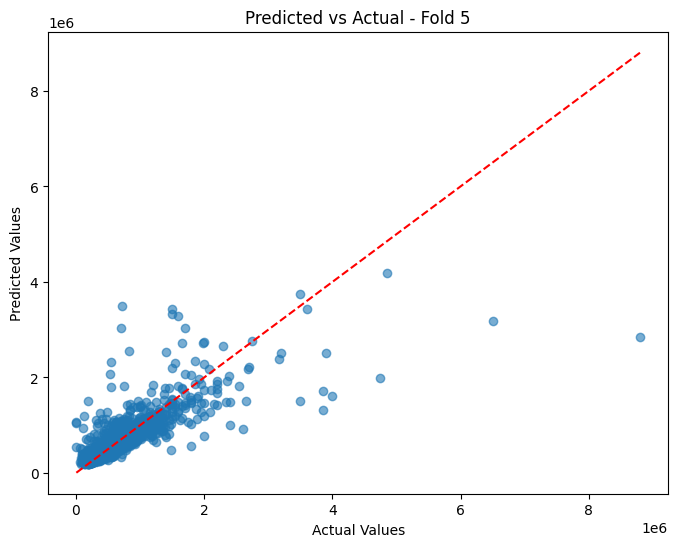

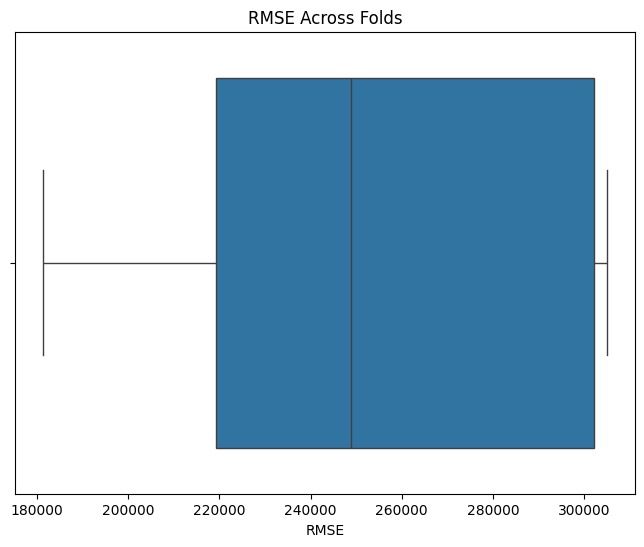

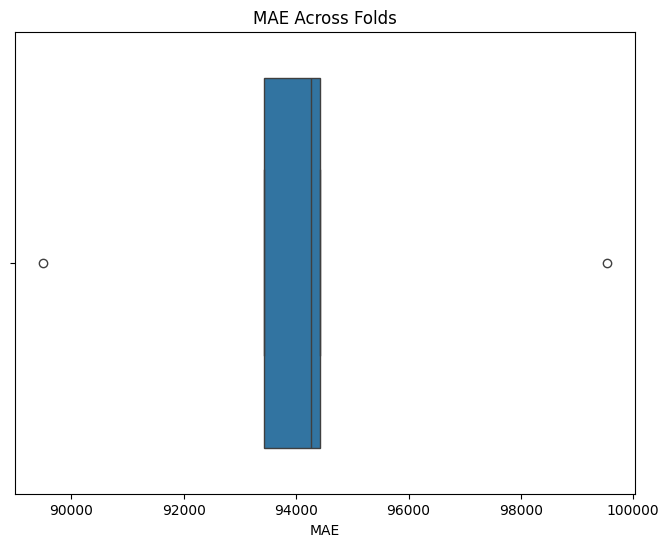

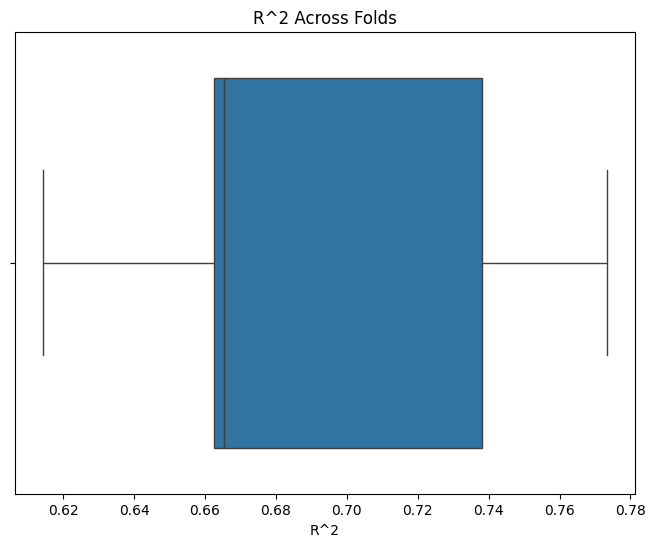

In [115]:
import seaborn as sns

# Example: Plot RMSE distribution across folds
sns.boxplot(data=rmse_scores)
plt.title("RMSE Across Folds")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.show()

# Plot residual distributions
plt.figure(figsize=(10, 6))
for fold, residual in enumerate(residuals, 1):
    sns.kdeplot(residual, label=f'Fold {fold}', fill=True, alpha=0.5)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residual Distributions Across Folds")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.legend()
plt.show()

# Target Distribution per Fold
plt.figure(figsize=(10, 6))
for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    sns.kdeplot(y.iloc[train_idx], label=f'Train Fold {fold}', fill=True, alpha=0.3)
    sns.kdeplot(y.iloc[test_idx], label=f'Test Fold {fold}', fill=False)
plt.title("Target Variable Distribution Across Folds")
plt.xlabel("Target Variable")
plt.ylabel("Density")
plt.legend()
plt.show()


# RMSE vs. Feature Importance per Fold
key_feature = 'livingAreaSqFt'
rmse_vs_importance = [
    (rmse_scores[fold], feature_importances[fold][X.columns.get_loc(key_feature)])
    for fold in range(n_splits)
]

rmse_values, importances = zip(*rmse_vs_importance)

plt.figure(figsize=(8, 6))
plt.scatter(importances, rmse_values)
plt.title("RMSE vs Feature Importance ('livingAreaSqFt')")
plt.xlabel("Feature Importance")
plt.ylabel("RMSE")
plt.show()


# RMSE vs. Target Variance per Fold
target_variances = [
    y.iloc[test_idx].var()
    for _, test_idx in kf.split(X)
]

plt.figure(figsize=(8, 6))
plt.scatter(target_variances, rmse_scores)
plt.title("RMSE vs Target Variance Across Folds")
plt.xlabel("Target Variance")
plt.ylabel("RMSE")
plt.show()

# Feature Interaction Heatmaps
target_variances = [
    y.iloc[test_idx].var()
    for _, test_idx in kf.split(X)
]

plt.figure(figsize=(8, 6))
plt.scatter(target_variances, rmse_scores)
plt.title("RMSE vs Target Variance Across Folds")
plt.xlabel("Target Variance")
plt.ylabel("RMSE")
plt.show()

# Correlation heatmap for training data in each fold
for fold, (train_idx, _) in enumerate(kf.split(X), 1):
    fold_corr = X.iloc[train_idx].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(fold_corr, cmap="coolwarm", annot=False)
    plt.title(f"Feature Correlation Heatmap - Fold {fold}")
    plt.show()

# Predicted vs. actual scatter plot
for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train and predict
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
        verbose_eval=False
    )
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"Predicted vs Actual - Fold {fold}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Performance Consistency Across Folds
# Boxplot for RMSE
plt.figure(figsize=(8, 6))
sns.boxplot(data=rmse_scores, orient='h')
plt.title("RMSE Across Folds")
plt.xlabel("RMSE")
plt.show()

# Boxplot for MAE
plt.figure(figsize=(8, 6))
sns.boxplot(data=r_scores, orient='h')
plt.title("MAE Across Folds")
plt.xlabel("MAE")
plt.show()

# Boxplot for R^2
plt.figure(figsize=(8, 6))
sns.boxplot(data=rmse_scores, orient='h')
plt.title("R^2 Across Folds")
plt.xlabel("R^2")
plt.show()





Analyzing feature importance for Fold 1...

Analyzing feature importance for Fold 2...

Analyzing feature importance for Fold 3...

Analyzing feature importance for Fold 4...

Analyzing feature importance for Fold 5...

Feature Importance Across Folds:
                       Feature  Average Importance
21              livingAreaSqFt        2.051969e+16
1                     latitude        4.078035e+15
22              numOfBathrooms        4.026214e+15
0                      zipcode        3.818120e+15
20                 lotSizeSqFt        3.731898e+15
2                    longitude        3.616655e+15
11                   yearBuilt        1.742989e+15
13             numOfAppliances        5.168857e+14
5               hasAssociation        5.067067e+14
15  numOfPatioAndPorchFeatures        2.441127e+14
4                 garageSpaces        1.728984e+14
23               numOfBedrooms        1.540901e+14
14        numOfParkingFeatures        1.245609e+14
24                numOfStories  

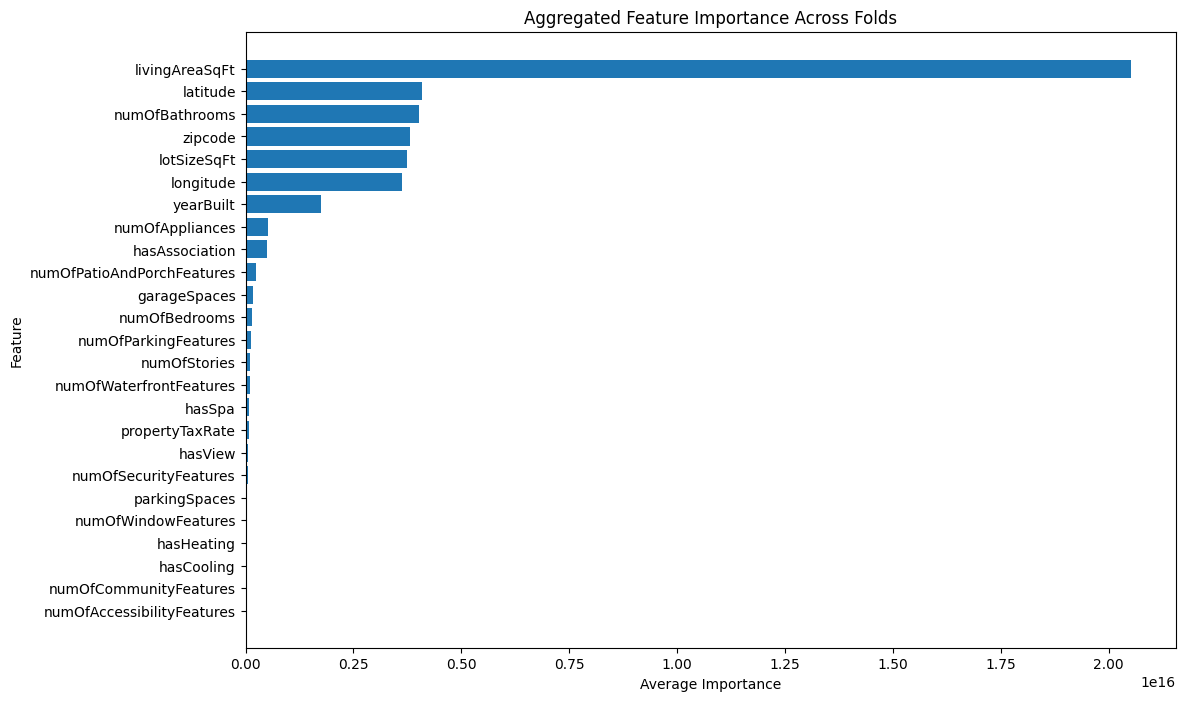

In [117]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Assuming 'X' (features) and 'y' (target) are already defined
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM parameters (replace with your optimized params if available)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.023205873385631175,
    'num_leaves': 69,
    'max_depth': 15,
    'min_data_in_leaf': 10,
    'lambda_l1': 0.02625378957858576,
    'lambda_l2': 3.795385000635995,
    'feature_fraction': 0.9723868045564107,
    'bagging_fraction': 0.8885744732151111,
    'bagging_freq': 5,
    'verbosity': -1
}

# Collect feature importance across folds
feature_importances = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nAnalyzing feature importance for Fold {fold + 1}...")

    # Split data for the current fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train LightGBM model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Collect feature importance for this fold
    importance = model.feature_importance(importance_type='gain')
    feature_importances.append(importance)

# Aggregate feature importance across all folds
avg_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Importance': avg_importance
}).sort_values(by='Average Importance', ascending=False)

print("\nFeature Importance Across Folds:")
print(feature_importance_df)

# Plot aggregated feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Aggregated Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()
